<a id='sommaire'></a>
<h1 style='text-align:center;border:5px double;border-color:gray;'>
    <br/>
    PROJET 7<br/>
    <br/>
    "Effectuez une prédiction de revenus"
    <br/>
    <br/>
    Partie 2: Etude de modèles<br/>
</h1>


In [1]:
#! coding:utf-8
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import t, shapiro, ks_2samp

os.makedirs('graphiques', exist_ok=True)

plt.style.use('ggplot')

In [2]:
print("Pandas, version: " + pd.__version__)
print("Numpy, version: " + pd.__version__)
print("Seaborn, version: " + sns.__version__)
print("Matplotlib, version: " + matplotlib.__version__)
print("Statsmodels, version: " + sm.__version__)

Pandas, version: 0.25.3
Numpy, version: 0.25.3
Seaborn, version: 0.9.0
Matplotlib, version: 3.1.2
Statsmodels, version: 0.10.2


In [3]:
"""from functions2 import *"""

'from functions2 import *'

## Créer un modèle permettant de déterminer le revenu potentiel d'une personne  
  

* Etude retrospective  
* Variable d'intérêt (dépendante, à expliquer): 'y_child' ou 'ln_y_child'  
* Facteur (variables indépendantes, explicatives): 'Pays', 'mj', 'ln_mj', 'Gj', 'c_i_parent'  
  
**Description des variable:**
  
**y_child**: revenu  
**ln_y_child**: logarithme de y_child  
**Pays**: Pays d'appartenance d'un individus  
**mj**: revenu moyen par pays  
**ln_mj**: logarithme de mj  
**Gj**: Indice de Gini du pays  
**c_i_parent**: classe de revenu des parent

<a id='anova'></a>
### ANOVA de la variable revenus des enfants en fonction du pays

#### Préparation et représentation des données

[Haut de page](#sommaire)

In [4]:
# Chargement des données
ready_db1 = pd.read_csv('data/analyse.csv')

ready_db1.head()

,Pays,y_child,Gj,pj,c_i_parent,mj,ln_y_child,ln_mj
0,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
1,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
2,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
3,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643
4,Albania,728.89795,0.32141,0.815874,1,2994.829902,6.591534,8.004643


In [5]:
# Agrégation pour gagner en temps de calculs
ready_db2 = ready_db1.groupby(by=['Pays',
                                  'y_child',
                                  'mj',
                                  'Gj',
                                  'pj',
                                  'ln_mj',
                                  'ln_y_child']).mean()
ready_db2.reset_index(inplace=True)
ready_db2.drop(columns=['c_i_parent'], inplace=True)

ready_db2.tail()

,Pays,y_child,mj,Gj,pj,ln_mj,ln_y_child
11595,Yemen,2568.6511,1042.63587,0.390259,0.916461,6.949507,7.851136
11596,Yemen,2893.9040,1042.63587,0.390259,0.916461,6.949507,7.970362
11597,Yemen,3307.2722,1042.63587,0.390259,0.916461,6.949507,8.103879
11598,Yemen,4137.0264,1042.63587,0.390259,0.916461,6.949507,8.327733
11599,Yemen,9050.4375,1042.63587,0.390259,0.916461,6.949507,9.110568


In [6]:
ready_db1.shape, ready_db2.shape

((5800000, 8), (11600, 7))

**Pour l'ensemble des tests, notre niveau de test sera:**
alpha = 0.05

#### Le pays d'origine a-t-il une influence sur le revenu?

**H0: Tous les pays ont le même revenu (tous les ${\alpha_i}$ sont nuls)**  
Le pays n'a pas d'influence sur le revenu enfant moyen  
  
**H1: Les revenus dépendent du pays (les ${\alpha_i}$ sont différents de 0)**  
Le pays a une influence sur le revenu

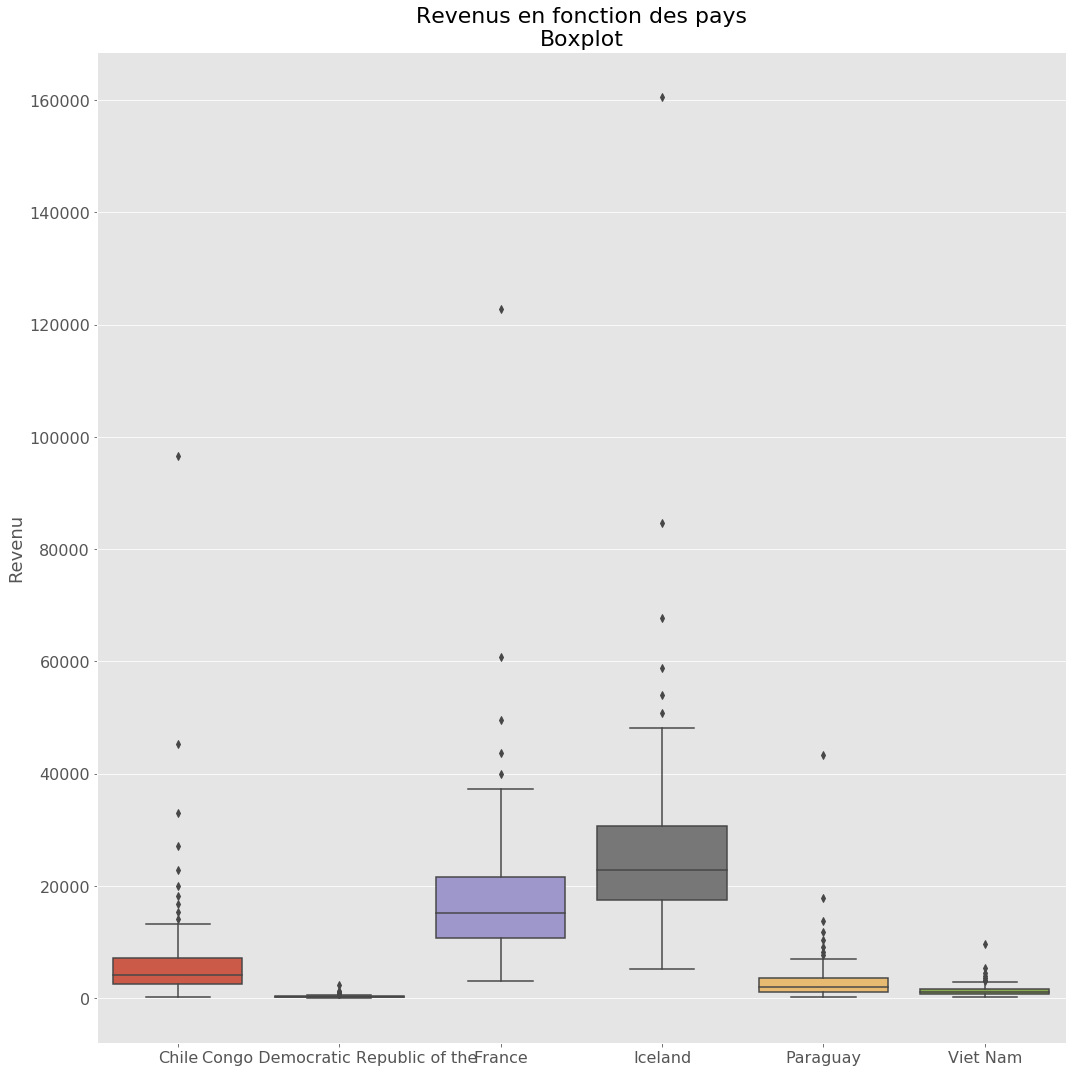

In [7]:
# Affichage des pays suivis
ready_db3 = ready_db2.loc[(ready_db2['Pays'] == 'France') | (ready_db2['Pays'] == 'Congo Democratic Republic of the') |
                          (ready_db2['Pays'] == 'Viet Nam') | (ready_db2['Pays'] == 'Chile') |
                          (ready_db2['Pays'] == 'Iceland') | (ready_db2['Pays'] == 'Paraguay')]

plt.figure(figsize=(15,15))

ax = sns.boxplot(x='Pays', y='y_child', data=ready_db3)

plt.ylabel('Revenu', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=16)
plt.title('Revenus en fonction des pays\nBoxplot', fontsize=22)

plt.tight_layout()

plt.savefig('graphiques/Revenus_en_fonction_des_pays_Boxplot.png')
plt.show()

In [8]:
# Réalisation de l'ANOVA
#Plan d'expérience complet et équilibré car  n_1 = ... = n_i = 100
alpha = 0.05

anova_pays = smf.ols('y_child~Pays', data=ready_db2).fit(alpha=alpha)

anova_pays.summary().tables[0]

Dep. Variable:,y_child,R-squared:,0.496
Model:,OLS,Adj. R-squared:,0.491
Method:,Least Squares,F-statistic:,98.43
Date:,"Fri, 17 Jan 2020",Prob (F-statistic):,0.00
Time:,16:41:22,Log-Likelihood:,-1.1862e+05
No. Observations:,11600,AIC:,2.375e+05
Df Residuals:,11484,BIC:,2.383e+05
Df Model:,115,,
Covariance Type:,nonrobust,,


R<sup>2</sup> = 0.496  
R<sup>2</sup><sub>ajusté</sub> = 0.491  
La variable pays explique près de 50% de la variance du revenu  
Les autres facteurs non considérés dans le modèle expliquent l'autre moitié de la variance du revenu

In [9]:
# Affichage des resultats du test de Fisher  (influence de la variable pays)
test = sm.stats.anova_lm(anova_pays, typ=1)
test

,df,sum_sq,mean_sq,F,PR(>F)
Pays,115.0,5.102375e+11,4.436848e+09,98.429271,0.0
Residual,11484.0,5.176586e+11,4.507651e+07,NaN,NaN


H0: ${\alpha_{argentine}}$ = ... = ${\alpha_{yemen}}$ = 0 (Le pays n'a pas d'influence)  
H1: ${\alpha_{argentine}}$ = ... = ${\alpha_{yemen}}$ != 0 (Le pays a une influence)  
La p-valeur du Test de Fischer est: ~0.0  
p-valeur <<< 0.05  
On rejette donc l'hypothèse H0 et on conclut que le pays a une influence sur le revenu

#### Vérification manuelle

In [10]:
# Carré Moyen de l'Erreur (CME) = Somme des Carrés de l'Expliqué (SCE) / (I - 1) - variance expliquée
# Où I est le nombre de pays
I = 116
SCE = test.iloc[0,1]
CME = SCE / (I - 1)
SCE, CME

(510237524303.9017, 4436848037.425232)

In [11]:
# CMR = Somme des Carrés de l'erreur Résiduelle (SCR) /  (I - n) - variance inexpliquée
# Où n est la taille de l'échantillon
n = 11600
SCR = test.iloc[1,1]
CMR = SCR / (n - I)
SCR, CMR

(517658642063.21796, 45076510.106514975)

In [12]:
# F = CME / CMR
# Où F est la statistique du test
F = CME / CMR
F

98.42927118672321

In [13]:
# R_2 = SCE/ Somme des Carrés Totales = SCE / (SCE + SCR)
R_2 = SCE / (SCE + SCR)
R_2

0.49639014231099593

In [14]:
# R_2_ajusté = 1 - (n/(n - p)(1-R_2))
R_2_Aj = 1 - ((1 - R_2)*(n - 1)/(n - I -1))

R_2_Aj

0.4913027310515756

#### Vérification de l'hypothèse gaussienne

[Haut de page](#sommaire)

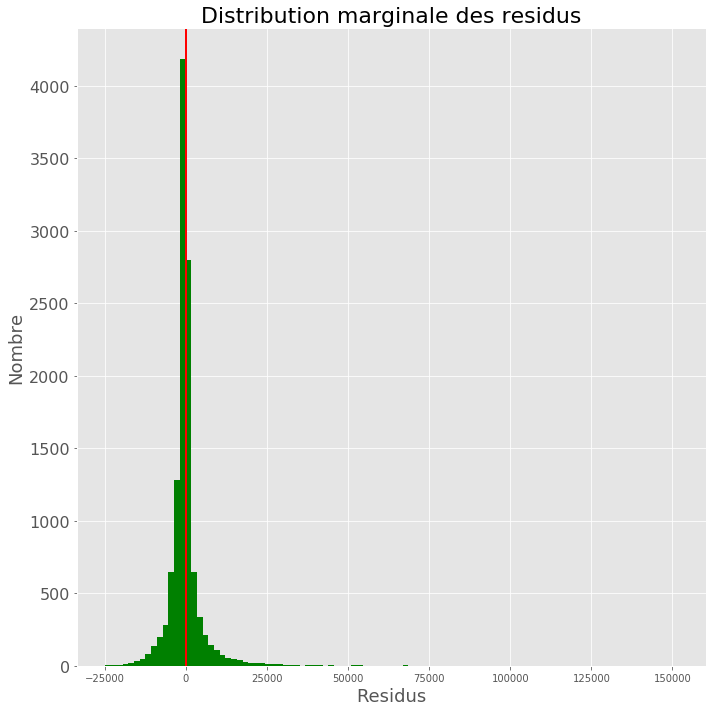

In [15]:
# Préparation des données
X = anova_pays.resid
Xbar = np.mean(X)
Xsprime = np.std(X)

#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X, 100, facecolor='g')
plt.axvline(Xbar, color='r', linewidth=2)

plt.title(f'Distribution marginale des residus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Residus',fontsize=18)
plt.yticks(fontsize=16)

plt.tight_layout()

plt.savefig('graphiques/Distribution_marginale_des_residus.png')
plt.show()

In [16]:
# Test de normalité Shapiro-Wilk pour vérifier la répartition selon une Normale des résidus
shapiro(X)

/home/alainux/anaconda3/envs/Projet8/lib/python3.8/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.56099933385849, 0.0)

Le test Shapiro-Wilk n'est pas adapté à nos données, qui sont trop nombreuses

In [17]:
# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
ks_2samp(X,list(np.random.normal(Xbar, Xsprime, 11600)))

Ks_2sampResult(statistic=0.24672413793103443, pvalue=4.315822718397994e-307)

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
p-value <<< 0.05, on rejette h0, y_child ne suit pas la loi normale(Xbar, XSprime)

In [18]:
# Test de Jarque-Bera
JB1, JBpv1, skw1, kurt1 = sm.stats.stattools.jarque_bera(X)
JB1, JBpv1, skw1, kurt1

(4207431.542160293, 0.0, 6.739339356074607, 95.32202335877405)

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
JBpv ~ 0, on rejette H0, d'après le test, les données ne suivent pas une loi normale

FileNotFoundError: [Errno 2] No such file or directory: 'graph/droite_henry_anova.png'

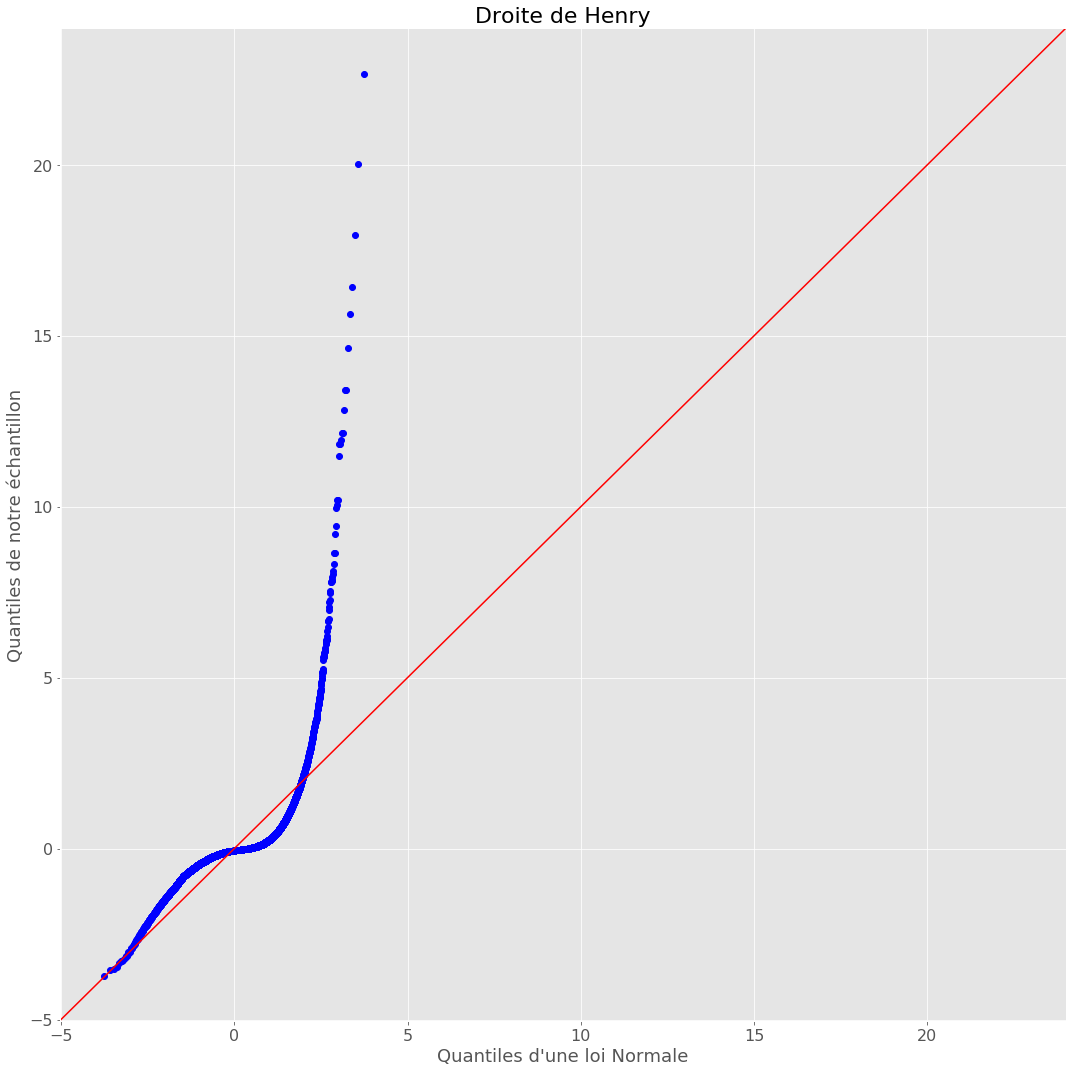

In [19]:
# Droite de Henry
# permet de visualiser l'écart à une loi Normale
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry', fontsize=22)

plt.tight_layout()

plt.savefig('graph/droite_henry_anova.png')
plt.show()

**Conclusion:**
Bien que les tests nous invitent à rejeter l'hypothèse gaussiene (répartition selon une loi Normale des résidus), la robustesse d'une ANOVA sur des échantillons de grande taille, nous permet d'accepter tout de même le résultat.

<a id='reg1'></a>
### Régression linéaire du revenu enfant sur le revenu moyen du pays et l'indice de Gini

#### Tests de significativité

[Haut de page](#sommaire)

In [ ]:
reg = smf.ols('y_child ~ Gj + mj', data=ready_db2)
reg_multi = reg.fit()
reg_multi.summary().tables[0]

**Test global:**  
H0: ${\beta_{GJ}}$ = ${\beta_{ymj}}$ = 0  
H1: ${\beta_{GJ}}$ = ${\beta_{ymj}}$ != 0  
F ~ 0.00 <<< ${\alpha}$, on rejette H0, le modèle est globalement significatif

In [ ]:
reg_multi.summary().tables[1]

 **Test de significativité des variables:**
   
H0: ${\beta_{GJ}}$ = 0  
H1: ${\beta_{GJ}}$ != 0  
Le paramètre ${\beta_{GJ}}$ de la variable Gj (indice de gini) n'est pas significatif au niveau de test alpha (0.05)  
En effet p-value ~ 1 > ${\alpha}$, on accepte H0, le paramètre n'est pas significatif (${\beta_{GJ}}$ = 0)  
  
H0: ${\beta_{ymj}}$ = 0  
H1: ${\beta_{ymj}}$ != 0  
Le paramètre ${\beta_{ymj}}$ de la variable mj est significatif au niveau de test ${\alpha}$ (0.05)  
En effet p-value ~ 0.00 <<< ${\alpha}$, on rejette H0, le paramètre est significatif (${\beta_{ymj}}$ != 0)

#### Passage au logarithme du revenu enfant

[Haut de page](#sommaire)

In [ ]:
reg_ln = smf.ols('ln_y_child ~ Gj + ln_mj', data=ready_db2)
reg_multi_ln = reg_ln.fit()

reg_multi_ln.summary().tables[0]

**Test global:**  
H0: ${\beta_{GJ}}$ = ${\beta_{ln_mj}}$ = 0  
H1: ${\beta_{GJ}}$ != ${\beta_{ln_mj}}$ != 0  
F ~ 0.00 <<< ${\alpha}$, on rejette H0, le modèle est globalement significatif  

In [ ]:
reg_multi_ln.summary().tables[1]

 **Test de significativité:**
   
H0: ${\beta_{GJ}}$ = 0  
H1: ${\beta_{GJ}}$ != 0  
Le paramètre ${\beta_{GJ}}$ de la variable Gj (indice de gini) est significatif au niveau de test ${\alpha}$ (0.05)  
En effet p-value ~ 0.00 <<< ${\alpha}$, on rejette H0, le paramètre est significatif (${\beta_{GJ}}$ != 0)  
  
H0: ${\beta_{ln_mj}}$ = 0  
H1: ${\beta_{ln_mj}}$ != 0  
Le paramètre ${\beta_{ln_mj}}$ de la variable ln_mj est significatif au niveau de test ${\alpha}$ (0.05)  
En effet p-value ~ 0.00 <<< ${\alpha}$, on rejette H0, le paramètre est significatif (${\beta_{ln_mj}}$ != 0)

#### Analyses de $R^2$

[Haut de page](#sommaire)

In [ ]:
# Anova sur les variables de notre régression linéaire
anova_ln = sm.stats.anova_lm(reg_multi_ln, typ=1)
anova_ln

In [ ]:
# Calcul du R2 pour la variable 'Gj'
r2_Gj = anova_ln.sum_sq['Gj'] / anova_ln['sum_sq'].sum()
r2_Gj

In [ ]:
# Calcul du R2 pour la variable 'ln_y_child'
r2_ln_mj = anova_ln.sum_sq['ln_mj'] / anova_ln['sum_sq'].sum()
r2_ln_mj

In [ ]:
# Vérification
r2_Gj + r2_ln_mj, reg_multi_ln.rsquared

In [ ]:
print(f'Dans notre modèle:\n\n\
La variable \'Gj\' explique {100 * r2_Gj:.2f}% de la variance de la variable \'ln_y_child\'\n\n\
La variable \'ln_mj\' explique {100 * r2_ln_mj:.2f}% de la variance de la variable \'ln_y_child\'\n\n\
Notre modèle explique {100 * reg_multi_ln.rsquared:.2f}% de la variance de la variable \'ln_y_child\'')

#### Analyse de l'atypicité sur les variables explicatives

Lorsque l'on réalise une régression, il convient d'étudier l'atypicité sur les variables explicatives.  

- Etude des leviers: les échantillons qui sont 'loin' de la majeure partie des autres individus de l'échantillon  
- Etude des résidus studentisés internes: Les points mal reconstitués par le modèle  

##### Les leviers

[Haut de page](#sommaire)

In [ ]:
# Paramètres de l'étude
n = ready_db2.shape[0]
p = 3

# Seuil levier selon Belsey
seuil_levier = 2 * p / n

In [ ]:
# Ajout des termes diagonaux de H
ready_db2['levier'] = reg_multi_ln.get_influence().hat_matrix_diag

ready_db2.sort_values(by='levier', ascending=False).head()

In [ ]:
ready_db2.sort_values(by='levier').head()

In [ ]:
ready_db4 = ready_db2.groupby(['Pays', 'mj', 'Gj', 'pj', 'ln_mj']).mean()
ready_db4.reset_index(inplace=True)

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(ready_db4.loc[ready_db4['levier'] <= seuil_levier]['Pays'],
        ready_db4.loc[ready_db4['levier'] <= seuil_levier]['levier'], color='g')

# Individus au dessus du seuil
plt.bar(ready_db4.loc[ready_db4['levier'] > seuil_levier]['Pays'],
        ready_db4.loc[ready_db4['levier'] > seuil_levier]['levier'], color='r')

# Décoration et annotations
plt.title('Représentation des leviers', fontsize=22)
plt.xlabel('Pays', fontsize=18)
plt.xticks('', fontsize=16)
plt.ylabel('Leviers', fontsize=18)
plt.yticks(fontsize=16)
plt.axhline(y=seuil_levier, color='b', linestyle='-')
plt.text(50, 0.000525 , 'Seuil levier', fontsize = '14', color='b')
plt.tight_layout()

plt.savefig('graphiques/Representation_des_leviers.png')
plt.show()

In [ ]:
# Nombre de valeurs atypiques sur les variables explicatives
lev_ln = ready_db2.loc[ready_db2['levier'] > seuil_levier, :]
len(lev_ln)

In [ ]:
# Pays presentants des valeurs atypiques
ready_db4.loc[ready_db4['levier'] > seuil_levier]

In [ ]:
ready_db4.sort_values(by='levier', ascending=False).head()

##### Analyse de l'atypicité sur la variable à expliquer (residus studentisés)

[Haut de page](#sommaire)

In [ ]:
# Détermination du seuil statistique d'atypicité
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
seuil_rstudent

In [ ]:
# statistique de test par observation
ready_db2['rstudent'] = reg_multi_ln.get_influence().resid_studentized_internal
ready_db2.sort_values(by='rstudent').head()

In [ ]:
ready_db2.sort_values(by='rstudent').tail()

In [ ]:
ready_db5 = ready_db2.groupby(['Pays', 'mj', 'Gj', 'pj', 'ln_mj', 'rstudent']).mean()
ready_db5.reset_index(inplace=True)

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(ready_db5.loc[(ready_db5['rstudent'] <= seuil_rstudent) & (ready_db5['rstudent'] >= -seuil_rstudent)].index,
        ready_db5.loc[(ready_db5['rstudent'] <= seuil_rstudent) & (ready_db5['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(ready_db5.loc[ready_db5['rstudent'] > seuil_rstudent].index,
        ready_db5.loc[ready_db5['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(ready_db5.loc[ready_db5['rstudent'] < -seuil_rstudent].index,
        ready_db5.loc[ready_db5['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# Décoration et annotations
plt.title('Représentation des résidus studentisés', fontsize=22)
plt.xlabel('Pays', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.ylabel('Résidus studentisés', fontsize=18)
plt.yticks(fontsize=16)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(5_000, 2.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(5_000, -2.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

plt.savefig('graphiques/Representation_des_résidus_studentises.png', dpi=300)
plt.show()

In [ ]:
ready_db_saf = ready_db5.loc[(ready_db5['Pays'] == 'South Africa')]

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(ready_db_saf.loc[(ready_db_saf['rstudent'] <= seuil_rstudent) & (ready_db_saf['rstudent'] >= -seuil_rstudent)].index,
        ready_db_saf.loc[(ready_db_saf['rstudent'] <= seuil_rstudent) & (ready_db_saf['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(ready_db_saf.loc[ready_db_saf['rstudent'] > seuil_rstudent].index,
        ready_db_saf.loc[ready_db_saf['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(ready_db_saf.loc[ready_db_saf['rstudent'] < -seuil_rstudent].index,
        ready_db_saf.loc[ready_db_saf['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# Décoration et annotations
plt.title('Représentation des résidus studentisés\nAfrique du Sud', fontsize=22)
plt.xlabel('Classes parents', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.yticks(fontsize=16)
plt.ylabel('Résidus studentisés', fontsize=18)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(9550, 2.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(9550, -2.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

plt.savefig('graphiques/Representation_des_residus_studentises_Afrique_du_Sud.png')
plt.show()

In [ ]:
ready_db_hon = ready_db5.loc[(ready_db5['Pays'] == 'Honduras')]

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(ready_db_hon.loc[(ready_db_hon['rstudent'] <= seuil_rstudent) & (ready_db_hon['rstudent'] >= -seuil_rstudent)].index,
        ready_db_hon.loc[(ready_db_hon['rstudent'] <= seuil_rstudent) & (ready_db_hon['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(ready_db_hon.loc[ready_db_hon['rstudent'] > seuil_rstudent].index,
        ready_db_hon.loc[ready_db_hon['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(ready_db_hon.loc[ready_db_hon['rstudent'] < -seuil_rstudent].index,
        ready_db_hon.loc[ready_db_hon['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# Décoration et annotations
plt.title('Représentation des résidus studentisés\npour le Honduras', fontsize=22)
plt.xlabel('Classes parents', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.yticks(fontsize=16)
plt.ylabel('Résidus studentisés', fontsize=18)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(4250, 2.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(4250, -2.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

plt.savefig('graphiques/Representation_des_residus_studentises_pour_le_Honduras.png')
plt.show()

In [ ]:
ready_db_kor = ready_db5.loc[(ready_db5['Pays'] == 'Korea Republic of')]

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(ready_db_kor.loc[(ready_db_kor['rstudent'] <= seuil_rstudent) & (ready_db_kor['rstudent'] >= -seuil_rstudent)].index,
        ready_db_kor.loc[(ready_db_kor['rstudent'] <= seuil_rstudent) & (ready_db_kor['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(ready_db_kor.loc[ready_db_kor['rstudent'] > seuil_rstudent].index,
        ready_db_kor.loc[ready_db_kor['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(ready_db_kor.loc[ready_db_kor['rstudent'] < -seuil_rstudent].index,
        ready_db_kor.loc[ready_db_kor['rstudent'] < -seuil_rstudent]['rstudent'], color='r')

# Décoration et annotations
plt.title('Représentation des résidus studentisés\npour la république de Corée', fontsize=22)
plt.xlabel('Classes parents', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.yticks(fontsize=16)
plt.ylabel('Résidus studentisés', fontsize=18)

plt.axhline(y=seuil_rstudent, color='b', linestyle='-')
plt.text(5650, 2.5 , 'Seuil rstudent', fontsize = '18', color='b')

plt.axhline(y=-seuil_rstudent, color='b', linestyle='-')
plt.text(5650, -2.5 , '-Seuil rstudent', fontsize = '18', color='b')

plt.tight_layout()

plt.savefig('graphiques/Representation_des_residus_studentises_pour_la_republique_de_Coree.png')
plt.show()

In [ ]:
# Nombre de valeurs atypiques sur les variables à expliquer
res_stu_ln = ready_db5.loc[(ready_db5['rstudent'] > seuil_rstudent) |
                             (ready_db5['rstudent'] < -seuil_rstudent)]

len(res_stu_ln)

In [ ]:
# Pays presentants des valeurs atypiques
ready_db5.loc[ready_db5.index.isin(res_stu_ln.index)].groupby(by='Pays').count().sort_values(by='y_child',
                                                                                             ascending=False).head(8)

#### Analyse de l'influence des observations

Lorsque l'on réalise une régression, il convient aussi d'étudier l'influence sur les variables explicatives.  

L'influence c'est déterminer l'importance sur la régression, la participation au modèle d'un individu

[Haut de page](#sommaire)

In [ ]:
# Création du dataframe avec tous les resultats d'influences disponibles
influence_ln = reg_multi_ln.get_influence().summary_frame()
influence_ln.head()

In [ ]:
# Ajout de la colonne distance de Cook à notre dataframe analyses_ln
ready_db2['dcooks'] = influence_ln['cooks_d']

# Seuil d'influence selon Cook
seuil_dcook = 4/(n-p)

ready_db2.sort_values(by='dcooks').head()

In [ ]:
ready_db2.sort_values(by='dcooks').tail()

In [ ]:
ready_db6 = ready_db2.groupby(['Pays', 'mj', 'Gj', 'pj', 'ln_mj', 'dcooks']).mean()
ready_db6.reset_index(inplace=True)

# Représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(ready_db6.loc[ready_db6['dcooks'] <= seuil_dcook].index,
        ready_db6.loc[ready_db6['dcooks'] <= seuil_dcook]['dcooks'],
       color='g')

# Individus au dessus le seuil
plt.bar(ready_db6.loc[ready_db6['dcooks'] > seuil_dcook].index,
        ready_db6.loc[ready_db6['dcooks'] > seuil_dcook]['dcooks'],
       color='r')

# Décoration et annotations
plt.title('Représentation de la distance de Cook', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.text(-400, (seuil_dcook + 0.00005), 'Seuil de Cook', fontsize = '18', color='b')
plt.axhline(y=seuil_dcook, color='b', linestyle='-')

plt.tight_layout()

plt.savefig('graphiques/Representation_de_la_distance_de_Cook.png')
plt.show()

In [ ]:
ready_db_saf1 = ready_db6.loc[ready_db6['Pays'] == 'South Africa']
ready_db_saf1.reset_index(inplace=True)

# Représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(ready_db_saf1.loc[ready_db_saf1['dcooks'] <= seuil_dcook].index,
        ready_db_saf1.loc[ready_db_saf1['dcooks'] <= seuil_dcook]['dcooks'],
       color='g')

# Individus au dessus le seuil
plt.bar(ready_db_saf1.loc[ready_db_saf1['dcooks'] > seuil_dcook].index,
        ready_db_saf1.loc[ready_db_saf1['dcooks'] > seuil_dcook]['dcooks'],
       color='r')

# Décoration et annotations
plt.title('Représentation de la distance de Cook\npour l\'Afrique du Sud', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.ylim(0,0.011)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.text(20, (seuil_dcook + 0.00005), 'Seuil de Cook', fontsize = '18', color='b')
plt.axhline(y=seuil_dcook, color='b', linestyle='-')

plt.tight_layout()

plt.savefig('graphiques/Representation_de_la_distance_de_Cook_pour_l_Afrique_du_Sud.png')
plt.show()

In [ ]:
ready_db_hon1 = ready_db6.loc[ready_db6['Pays'] == 'Honduras']
ready_db_hon1.reset_index(inplace=True)

# Représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(ready_db_hon1.loc[ready_db_hon1['dcooks'] <= seuil_dcook].index,
        ready_db_hon1.loc[ready_db_hon1['dcooks'] <= seuil_dcook]['dcooks'],
       color='g')

# Individus au dessus le seuil
plt.bar(ready_db_hon1.loc[ready_db_hon1['dcooks'] > seuil_dcook].index,
        ready_db_hon1.loc[ready_db_hon1['dcooks'] > seuil_dcook]['dcooks'],
       color='r')

# Décoration et annotations
plt.title('Représentation de la distance de Cook\npour le Honduras', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.ylim(0,0.011)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.text(20, (seuil_dcook + 0.00005), 'Seuil de Cook', fontsize = '18', color='b')
plt.axhline(y=seuil_dcook, color='b', linestyle='-')

plt.tight_layout()

plt.savefig('graphiques/Representation_de_la_distance_de_Cook_pour_le_honduras.png')
plt.show()

In [ ]:
# Nombre d'observations influentes
dco_ln = ready_db2.loc[ready_db2['dcooks'] > seuil_dcook]
len(dco_ln)

In [ ]:
# Pays présentants des obervations au dela du seuil
ready_db6.loc[ready_db6.index.isin(dco_ln.index)].groupby(by='Pays').count().sort_values(by='y_child',
                                                                                         ascending=False).head(10)

#### Mesures atypiques et influentes

Les points problèmatique lors d'une régression, sont les points à la fois atypique et influent.

[Haut de page](#sommaire)

In [ ]:
ready_db2.head()

In [ ]:
# Obeservations atypiques et influentes
ind_aty_infl_ln = ready_db2.loc[((ready_db2['dcooks'] > seuil_dcook) &
                                  (ready_db2['rstudent'] > seuil_rstudent) &
                                  (ready_db2['levier'] > seuil_levier)) |
                                  ((ready_db2['dcooks'] > seuil_dcook) &
                                  (ready_db2['rstudent'] < -seuil_rstudent) &
                                  (ready_db2['levier'] > seuil_levier))]
len(ind_aty_infl_ln)

In [ ]:
# Pays contenants les observations influentes et atypiques
susp_pt = ready_db2.loc[ready_db2.index.isin(ind_aty_infl_ln.index)]
susp_pt.reset_index(inplace=True)
susp_pt.groupby('Pays').count()

**Concluion:** Seul deux pays sont concernés par des problèmes et d'atypicité et d'influence. Et seulement pour une partie (- de 30%) de leur observations. Notre régression est donc valable.

#### Détection des problèmes de colinéarité

Pour régression, les variables doivent être non colinéaires, sinon, il n'existe pas de solution unique au problème.

[Haut de page](#sommaire)

In [ ]:
# Facteur d'influence de la variance (Variance Inflation Factor)
mat_cor = np.corrcoef(ready_db2.ln_mj, ready_db2.Gj)
print(f"VIF: {1 / (1-(mat_cor[0,1]**2)):.2f} pour une corrélation de {mat_cor[0,1]:.2f} entre nos variables explicatives")

* VIF_Gj et VIF_ln_y_child_moy < 10 (ou même 5)   
**Nous n'avons pas de problème de colinéarité**

#### Test d'homoscédasticité

Pour que notre régression soit valable, il faut que la variance de nos résidus soit uniforme.  
Il faut qu'il y ait une homoscedasticité de nos résidus.

[Haut de page](#sommaire)

In [ ]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi_ln.resid, reg_multi_ln.model.exog)
print(f"p-value du test Breusch Pagan: {pval}")

H0: Homoscédasticité  
H1: Hétéroscédasticité  
p-value <<< ${\alpha}$, rejet de H0, il y a hétéroscédasticité des residus  
Encore une fois, le modèle de regression linéaire multiple est suffisamment robuste pour les grands échantillons. Comme dans notre cas.  
Plus on a de données à disposition, plus le modèle est capable de supporter des écarts important aux hypothèse (gaussienne et homoscédastique)

In [ ]:
# Représentation des résidus en fonction des valeurs prédites
plt.figure(figsize=(6,6))

plt.scatter(reg_multi_ln.resid, reg_multi_ln.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

plt.savefig('graphiques/homoscedasticite.png')
plt.show()

#### Test de normalité des résidus

[Haut de page](#sommaire)

In [ ]:
# Préparation des données
X_ln = reg_multi_ln.resid
Xbar_ln = np.mean(X_ln)
Xsprime_ln = np.std(X_ln)

# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
ks_2samp(reg_multi_ln.resid, list(np.random.normal(Xbar_ln, Xsprime_ln, 11_600)))

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
p-value <<< 0.05, on rejette H0, y_child ne suit pas une loi normale

In [ ]:
# Test de Jarque-Bera (test de normalité basé sur le kurtosis et le skewness)
JB_ln, JBpv_ln, skw_ln, kurt_ln = sm.stats.stattools.jarque_bera(reg_multi_ln.resid)
print(f"p-value: {JBpv_ln}")

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
JBpv ~ 0, on rejette H0, d'après le test, les données ne suivent pas une loi normale

In [ ]:
# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(reg_multi_ln.resid, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale', fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry')

plt.tight_layout()

plt.savefig('graphiques/droite_henry.png')
plt.show()

La droite de Henry represente la distribution empirique des residus et la distribution théorique d'une loi normale.  
Sauf pour les valeurs faibles de nos résidus, nos residus semblent plutôt alignés avec la distribution théorique d'une loi normale.

In [ ]:
#Représentation de la distribution marginale
plt.figure(figsize=(10,10,))

plt.hist(X_ln, 100, facecolor='g',)
plt.axvline(Xbar_ln, color='r', linewidth=2)

plt.title(f'Distribution marginale des résidus', fontsize=22)
plt.ylabel('Nombre', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Résidus', fontsize=18)
plt.xticks(fontsize=16)

plt.tight_layout()

plt.savefig('graphiques/Distribution marginale des résidus_regression_1.png')
plt.show()

<a id='reg2'></a>
### Régression linéaire du revenu enfant sur le revenu moyen du pays, l'indice de Gini et la classe de revenus des parents

##### Tests de significativité

[Haut de page](#sommaire)

In [ ]:
reg2 = smf.ols('y_child ~ Gj + mj + c_i_parent', data=ready_db1)
reg_multi2 = reg2.fit()
reg_multi2.summary().tables[0]

**Test global:**  
H0: ${\beta_{GJ}}$ = ${\beta_{mj}}$ = ${\beta_{ci\_parent}}$ = 0  
H1: ${\beta_{GJ}}$ != ${\beta_{mj}}$ = ${\beta_{ci\_parent}}$ != 0  
F ~ 0.00 <<< ${\alpha}$, on rejette H0, le modèle est globalement significatif

In [ ]:
reg_multi2.summary().tables[1]

 **Test de significativité:**
   
H0: ${\beta_{GJ}}$ = 0  
H1: ${\beta_{GJ}}$ != 0  
Le paramètre ${\beta_{GJ}}$ de la variable Gj (indice de gini) n'est pas significatif au niveau de test ${\alpha}$ (0.05)  
En effet p-value ~ 1 > ${\alpha}$, on accepte H0, le paramètre n'est pas significatif (${\beta_{GJ}}$ = 0)  
  
H0: ${\beta_{mj}}$ = 0  
H1: ${\beta_{mj}}$ != 0  
Le paramètre ${\beta_{mj}}$ de la variable mj est significatif au niveau de test ${\alpha}$ (0.05)  
En effet p-value ~ 0.00 <<< ${\alpha}$, on rejette H0, le paramètre est significatif (${\beta_{mj}}$ != 0)  
  
H0: ${\beta_{ci\_parent}}$ = 0  
H1: ${\beta_{ci\_parent}}$ != 0  
Le paramètre ${\beta_{ci\_parent}}$ de la variable c_i_parent est significatif au niveau de test ${\alpha}$ (0.05)  
En effet p-value ~ 0.00 <<< ${\alpha}$, on rejette H0, le paramètre est significatif (${\beta_{ci\_parent}}$ != 0) 

#### Passage au logarithme du revenu enfant

[Haut de page](#sommaire)

In [ ]:
reg_ln2 = smf.ols('ln_y_child ~ Gj + ln_mj + c_i_parent', data=ready_db1)
reg_multi_ln2 = reg_ln2.fit()

reg_multi_ln2.summary().tables[0]

**Test global:**  
H0: ${\beta_{GJ}}$ = ${\beta_{ln\_mj}}$ = ${\beta_{ci\_parent}}$ = 0  
H1: ${\beta_{GJ}}$ != ${\beta_{ln\_mj}}$ = ${\beta_{ci\_parent}}$ != 0  
F ~ 0.00 <<< ${\alpha}$, on rejette H0, le modèle est globalement significatif

In [ ]:
reg_multi_ln2.summary().tables[1]

**Test de significativité:**
   
H0: ${\beta_{GJ}}$ = 0  
H1: ${\beta_{GJ}}$ != 0  
Le paramètre ${\beta_{GJ}}$ de la variable Gj (indice de gini) n'est pas significatif au niveau de test ${\alpha}$ (0.05)  
En effet p-value ~ 0<<< ${\alpha}$, on rejette H0, le paramètre est significatif (${\beta_{GJ}}$ = 0)  
  
H0: ${\beta_{ln\_mj}}$ = 0  
H1: ${\beta_{ln\_mj}}$ != 0  
Le paramètre ${\beta_{ln\_mj}}$ de la variable ln_mj est significatif au niveau de test ${\alpha}$ (0.05)  
En effet p-value ~ 0.00 <<< ${\alpha}$, on rejette H0, le paramètre est significatif (${\beta_{ln\_mj}}$ != 0)  
  
H0: ${\beta_{ci\_parent}}$ = 0  
H1: ${\beta_{ci\_parent}}$ != 0  
Le paramètre ${\beta_{ci\_parent}}$ de la variable c_i_parent est significatif au niveau de test ${\alpha}$ (0.05)  
En effet p-value ~ 0.00 <<< ${\alpha}$, on rejette H0, le paramètre est significatif (${\beta_{ci\_parent}}$ != 0)  

#### Analyses de $R^2$

[Haut de page](#sommaire)

In [ ]:
# Anova sur notre régression linéaire
anova2 = sm.stats.anova_lm(reg_multi_ln2, typ=1)
anova2

In [ ]:
# Calcul du R2 pour la variable 'c_i_parent'
r2_c_i_parent = anova2.iloc[2,1] / anova2['sum_sq'].sum()
r2_c_i_parent

In [ ]:
# Vérification
r2_Gj + r2_ln_mj + r2_c_i_parent, reg_multi_ln2.rsquared

In [ ]:
print(f'Dans notre modèle:\n\n\
La variable \'Gj\' explique {100 * r2_Gj:.2f}% de la variance de la variable \'ln_y_child\'\n\n\
La variable \'ln_y_child_moy\' explique {100 * r2_ln_mj:.2f}% de la variance de la variable \'ln_y_child\'\n\n\
La variable \'c_i_parent\' explique {100 * r2_c_i_parent:.2f}% de la variance de la variable \'ln_y_child\'\n\n\
Notre modèle explique {100 * reg_multi_ln2.rsquared:.2f}% de la variance de la variable \'ln_y_child\'')

#### Détection des problèmes de colinéarité

[Haut de page](#sommaire)

In [ ]:
# Facteur d'influence de la variance (Variance Inflation Factor)
variables_ln2 = reg_multi_ln2.model.exog
[variance_inflation_factor(variables_ln2, i) for i in np.arange(1,variables_ln2.shape[1])]

 * VIF_Gj et VIF_ln_y_child_moy < 10 (ou 5)  
Pas de problème de colinéarité

#### Test d'homoscédasticité

[Haut de page](#sommaire)

In [ ]:
_, pval2, __, f_pval2 = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi_ln2.resid, variables_ln2)
print('p value test Breusch Pagan:', pval2)

H0: Homoscédasticité  
H1: Hétéroscédasticité  
pvalue <<< ${\alpha}$, rejet de H0, il y a hétéroscédasticité des residus  
Toutefois, le modèle de regression linéaire multiple est robuste pour les grands échantillon. 5_800_000 ici, c'est notre cas.  
Plus on a de données à disposition, plus le modèle est capable de supporter des écarts important aux hypothèse (gaussienne et homoscédastique)

In [ ]:
# Représentation des résidus en fonction des valeurs prédites
plt.figure(figsize=(6,6))

plt.scatter(reg_multi_ln2.resid, reg_multi_ln2.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

plt.savefig('graphiques/homoscedasticite_regression_2.png')
plt.show()

#### Test de normalité des résidus

[Haut de page](#sommaire)

In [ ]:
# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
X_ln2 = reg_multi_ln2.resid
Xbar_ln2 = np.mean(X_ln2)
Xsprime_ln2 = np.std(X_ln2)

ks_2samp(reg_multi_ln2.resid, list(np.random.normal(Xbar_ln2, Xsprime_ln2, 5_800_000)))

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
p-value <<< 0.05, on rejette H0, y_child ne suit pas une loi normale

In [ ]:
# Test de Jarque-Bera (test de normalité basé sur le kurtosis et le skewness)
JB_ln1, JBpv_ln1, skw_ln1, kurt_ln1 = sm.stats.stattools.jarque_bera(reg_multi_ln2.resid)
print(f"p-value: {JBpv_ln1}")

H0: Les données suivent une loi normale  
H1: Les données ne suivent pas une loi normale  
JBpv ~ 0, on rejette H0, d'après le test, les données ne suivent pas une loi normale

In [ ]:
# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X_ln2, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry',fontsize=22)

plt.tight_layout()

plt.savefig('graphiques/droite_henry_regression_2.png')
plt.show()

In [ ]:
#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X_ln2, 100, facecolor='g')
plt.axvline(Xbar_ln2, color='r', linewidth=2)

plt.title(f'Distribution marginale des résidus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Résidus', fontsize=18)
plt.xticks(fontsize=16)

plt.tight_layout()

plt.savefig('graphiques/Distribution_marginale_des_residus_regression_2.png')
plt.show()

<a id='ccl'></a>
## Conclusion

[Haut de page](#sommaire)

In [ ]:
aic = [anova_pays.aic, reg_multi_ln.aic, reg_multi_ln2.aic, ]
bic = [anova_pays.bic, reg_multi_ln.bic, reg_multi_ln2.bic, ]
R2 = [100 * anova_pays.rsquared, 100 * reg_multi_ln.rsquared, 100 * reg_multi_ln2.rsquared, ]
model_ccl = pd.DataFrame({'AIC': aic,
                          'BIC': bic,
                          'R2': R2},
                        index= ['ANOVA', 'Reg_mj_Gj', 'Reg_mj_Gj_Cip'])

model_ccl = model_ccl[['AIC', 'BIC', 'R2']].round(1)

model_ccl

En étudiant l’information de kullback:
-AIC (Akaike Information Criturium)
-BIC (Bayesian Information Criterium - Schwarz Bayesian Criterium)
Nous conservons le modèle régression sur le revenu moyen et l’indice de Gini.
C’est le modèle avec le meilleur compromis entre l'ajustement du modèle (variance résiduelle faible) et qualité de prévision (nombre de variables explicatives faible, principe de parcimonie)

[Haut de page](#sommaire)

**Bonus:** La courbe de Gatsby le magnifique (Greg Mankiv) permet de visualiser la corrélation entre la distribution des revenus et la mobilité intergénérationnelle.

In [ ]:
# Préparation des données
y = ready_db2.Gj
x = ready_db2.pj

# Calcul du coefficient de corrélation
pear = scipy.stats.pearsonr(x,y)[0]

# Cacul des paramètres
slope, intercept, _, __, ___ = scipy.stats.linregress(x, y)

# Droite de régression
fitLine = slope * x + intercept

# Courbe de Gatsby
plt.figure(figsize=(10,10))
plt.plot(x, fitLine, c='g')
plt.scatter(x, y, c='g')
plt.text(0.45, 0.1, f'Coefficient de corrélation: {pear:.2}', color='r', fontsize=18)

# Décoration
plt.title('Courbe de Gatsby', fontsize=22)
plt.ylabel('Incide de Gini', fontsize=18)
plt.ylim(0, 1)
plt.yticks(fontsize=16)
plt.xlabel('Coefficient d\'élasticité', fontsize=18)
plt.xticks(fontsize=16)
plt.xlim(0, 1)



plt.savefig('graphiques/courbe_gatsby.png')
plt.show()